# Title: csck700_graph_enrichment

### The graph_enrichment module builds upon the bSDD metadata retrieved in csck700_3_bsdd_api to semantically enrich the existing IFC-derived property graph. It integrates canonical information from IFC 4.3 Property Sets and ETIM classification nodes, establishing links between assets, their corresponding Property Sets, and the related IFC and ETIM properties.  
### When enriched properties lack explicit associations in the IFC source, the module creates dedicated placeholder nodes (e.g., “Unresolved_Pset” or “Unresolved_Class”) to maintain structural consistency within the graph. The result is a unified, semantically enriched graph that consolidates IFC 4.3 and ETIM domains for downstream analysis and potential AI readiness.

In [4]:
from IPython.display import Image, display

In [2]:
picture_path = r"..\references\graph_enrichment_layer.jpg"

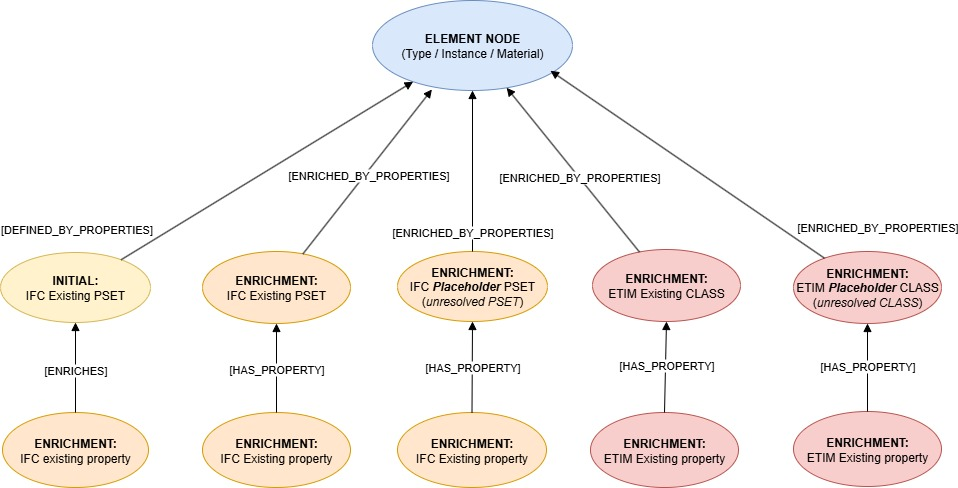

In [3]:
display(Image(filename=picture_path))

### SCHEMA TO UPDATE:
### 1. ORPHAN PROPERTIES + PLACEHOLDER (IFC PSET / ETIM CLASS) & SAME EDGES/RELATIONSHIPS THAN NON-ORPHAN PROPERTIES.
### 2. NEW IFC PROPERTY SET -> PROPERTY + [HAS_PROPERTY] EDGE.
### 3. INITAL IFC EXISTING PSET --> ALSO [HAS_PROPERTY] EDGE (FAVOR UNIFORMITY OF ENRICHMENT FOR QUERY).
### CONSISTENCY -> FINAL EVALUATION.

# 0.Table of content:

- [1. Settings:](#1.-Settings:)  
- [2. Imports:](#2.-Imports:)  
- [3. Helper functions:](#3.-Helper-functions:)   
- [4. Data load:](#4.-Data-load:)  
- [5. Compiling datasets for graph enrichment:](#5.-Compiling-datasets-for-graph-enrichment:)    
- [6. Graph enrichment:](#6.-Graph-enrichment:)
- [7. Post enrichment validation:](#7.-Post-enrichment-validation:)
- [8. Data save:](#8.-Data-save:)   

# 1. Settings:

# 2. Imports:

In [4]:
import pandas as pd
from pandas import StringDtype
# !pip install openpyxl
import openpyxl
import warnings
warnings.simplefilter("ignore", UserWarning)

# 3. Helper functions:

# 4. Data load:

In [5]:
file_path = r"..\data\processed\all_mappings.xlsx"

In [6]:
xls = pd.ExcelFile(file_path)
df_names = xls.sheet_names
print(df_names)

['stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']


In [7]:
dfs = dict()
for df_name in df_names:
    dfs[df_name] = pd.read_excel(file_path, sheet_name=df_name)

In [8]:
for name, df in dfs.items():
    print(f"\n### Dataframe: {name} ###")
    display(df.head(10))


### Dataframe: stone_wall_chimney ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,compressive strength,≥ 14 MPa (at 28 days minimum for masonry assem...,≥,14,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.1.1 / §2.1.2 / §3.6.1.2,ASTM C1314 / ASTM C476 / TMS 402,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,density,lightweight / medium / normal weight (ASTM C90...,enum,"{lightweight, medium, normal}",NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.3.2.6,ASTM C90 / ASTM C129,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,weather exposure,units to include water-repellent admixture for...,=,water-repellent required for exterior use,NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.3.2.5,ASTM C216 / TMS 402,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,fire rating,equivalent thickness 68–157 mm for 2–4 hour ra...,range,68–157,mm,Type,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.3.5,ACI 216.1,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,mortar type,ASTM C270 Type M / S / N (as specified for use),enum,"{M, S, N}",NaN,Material,False,...,https://identifier.buildingsmart.org/uri/etim/...,EC003182,Brickwork/pointing mortar,NaN,UFGS 04 20 00,§2.5.1,ASTM C270 / ASTM C1714,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,grout compressive strength,≥ 14 MPa (minimum per ASTM C476 / C1019),≥,14,MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.5.2,ASTM C476 / ASTM C1019,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,thermal resistance,typical assembly R-value ≈ 0.2–0.3 m²·K/W per ...,range,0.2–0.3,m²·K/W,Type,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.3.2 / §2.2.3.5,ACI 216.1 / ASHRAE 90.1,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MP,≥,7,MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§ 2.2.5,ASTM C880,NaN,NaN,NaN



### Dataframe: roof_wood_beam ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beam_001,Roof Wood Beam,IfcBeam,bending strength,"7,200 – 8,300 kPa (Fb)",range,7.2 – 8.3,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2.1,AWC NDS,NaN,NaN,NaN
1,beam_002,Roof Wood Beam,IfcBeam,tensile strength,"4,800 kPa (Ft)",=,4.8,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2.1,AWC NDS,NaN,NaN,NaN
2,beam_003,Roof Wood Beam,IfcBeam,compressive strength,"5,400 kPa (Fc)",=,5.4,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2.1,AWC NDS,NaN,NaN,NaN
3,beam_004,Roof Wood Beam,IfcBeam,modulus of elasticity,"8,300 MPa (E)",=,"8,300",MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2.1,AWC NDS,NaN,NaN,NaN
4,beam_005,Roof Wood Beam,IfcBeam,shear strength,"1,550 kPa (Fv)",=,1.55,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1.5.1 + §2.2.3,ASTM D2344 / ANSI AITC A190.1,NaN,NaN,NaN
5,beam_007,Roof Wood Beam,IfcBeam,fire rating,Fire-retardant treated; ASTM E84,=,Pass,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§1.8 / §2.2,ASTM E84,NaN,NaN,NaN
6,beam_008,Roof Wood Beam,IfcBeam,preservative retention,"CCA, AWPA U1",=,CCA,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§1.7 / §2.2,AWPA U1 / T1,NaN,NaN,NaN
7,beam_009,Roof Wood Beam,IfcBeam,durability,"Natural decay-resistant wood – redwood, cedar,...",=,Durable species,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1.4,AWPA U1 / EN 350,NaN,NaN,NaN



### Dataframe: strip_footing ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,footing_001,Strip Footing,IfcFooting,compressive strength,25 – 35 MPa (@ 28 days),=,30,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 01,§ 2.5.2.2 / § 3.14.3.4,ASTM C39,NaN,NaN,NaN
1,footing_003,Strip Footing,IfcFooting,water cement ratio,≤ 0.45,≤,0.45,w/cm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 2.5.2.2,ACI 211.1 / ACI 211.2,NaN,NaN,NaN
2,footing_004,Strip Footing,IfcFooting,maximum aggregate size,19 – 25 mm,≤,25,mm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 2.3.3.1,ASTM C33,NaN,NaN,NaN
3,footing_006,Strip Footing,IfcFooting,reinforcement grade,Grade 60 (typ.),=,60,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 2.6.1,ASTM A615,NaN,NaN,NaN
4,footing_007,Strip Footing,IfcFooting,reinforcement coating,Epoxy-coated / uncoated,=,epoxy / none,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 2.6.1.2 / § 2.6.1.3 / § 2.6.1.4,ASTM A775 / A934 / A1055 / A955,NaN,NaN,NaN
5,footing_008,Strip Footing,IfcFooting,reinforcement spacing,≤ 150 mm (o.c.),≤,150,mm,Type,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 3.5.11,ACI 315,NaN,NaN,NaN
6,footing_009,Strip Footing,IfcFooting,concrete cover to reinforcement,≥ 75 mm,≥,75,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 3.5.12,ACI 318 Tbl 20.6.1.3.1,NaN,NaN,NaN
7,footing_010,Strip Footing,IfcFooting,curing period,≥ 7 days (normal cement),≥,7,days,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§ 3.13.2,ACI 301 § 5.3,NaN,NaN,NaN



### Dataframe: beam_shoe ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beamshoe_001,Beam Shoe,IfcDiscreetAccessory,material designation,ASTM A36/A36M structural carbon steel,=,A36,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.1,ASTM A36/A36M,NaN,NaN,NaN
1,beamshoe_002,Beam Shoe,IfcDiscreetAccessory,coating type,"Hot-dip galvanized, Z275 (G90)",=,Z275 (G90),NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.3.1,ASTM A123/A153/A653/A924,NaN,NaN,NaN
2,beamshoe_003,Beam Shoe,IfcDiscreetAccessory,strength grade,Anchor bolts: F1554 Grade 55,=,F1554 Gr 55,ksi,Type,True,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.8,ASTM F1554,NaN,NaN,NaN
3,beamshoe_004,Beam Shoe,IfcDiscreetAccessory,weld type,Per AWS D1.1/D1.1M – Structural Welding Code (...,=,AWS D1.1/D1.1M,NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§3.5,AWS D1.1/D1.1M,NaN,NaN,NaN


# 5. Compiling datasets for graph enrichment:

## 5.1. Authoring Excell file parsing strategy:

### 5.1.1. Parsing workflow:

In [8]:
authoring_parsing_path = r"..\references\graph_enrichment_workflow.jpg"

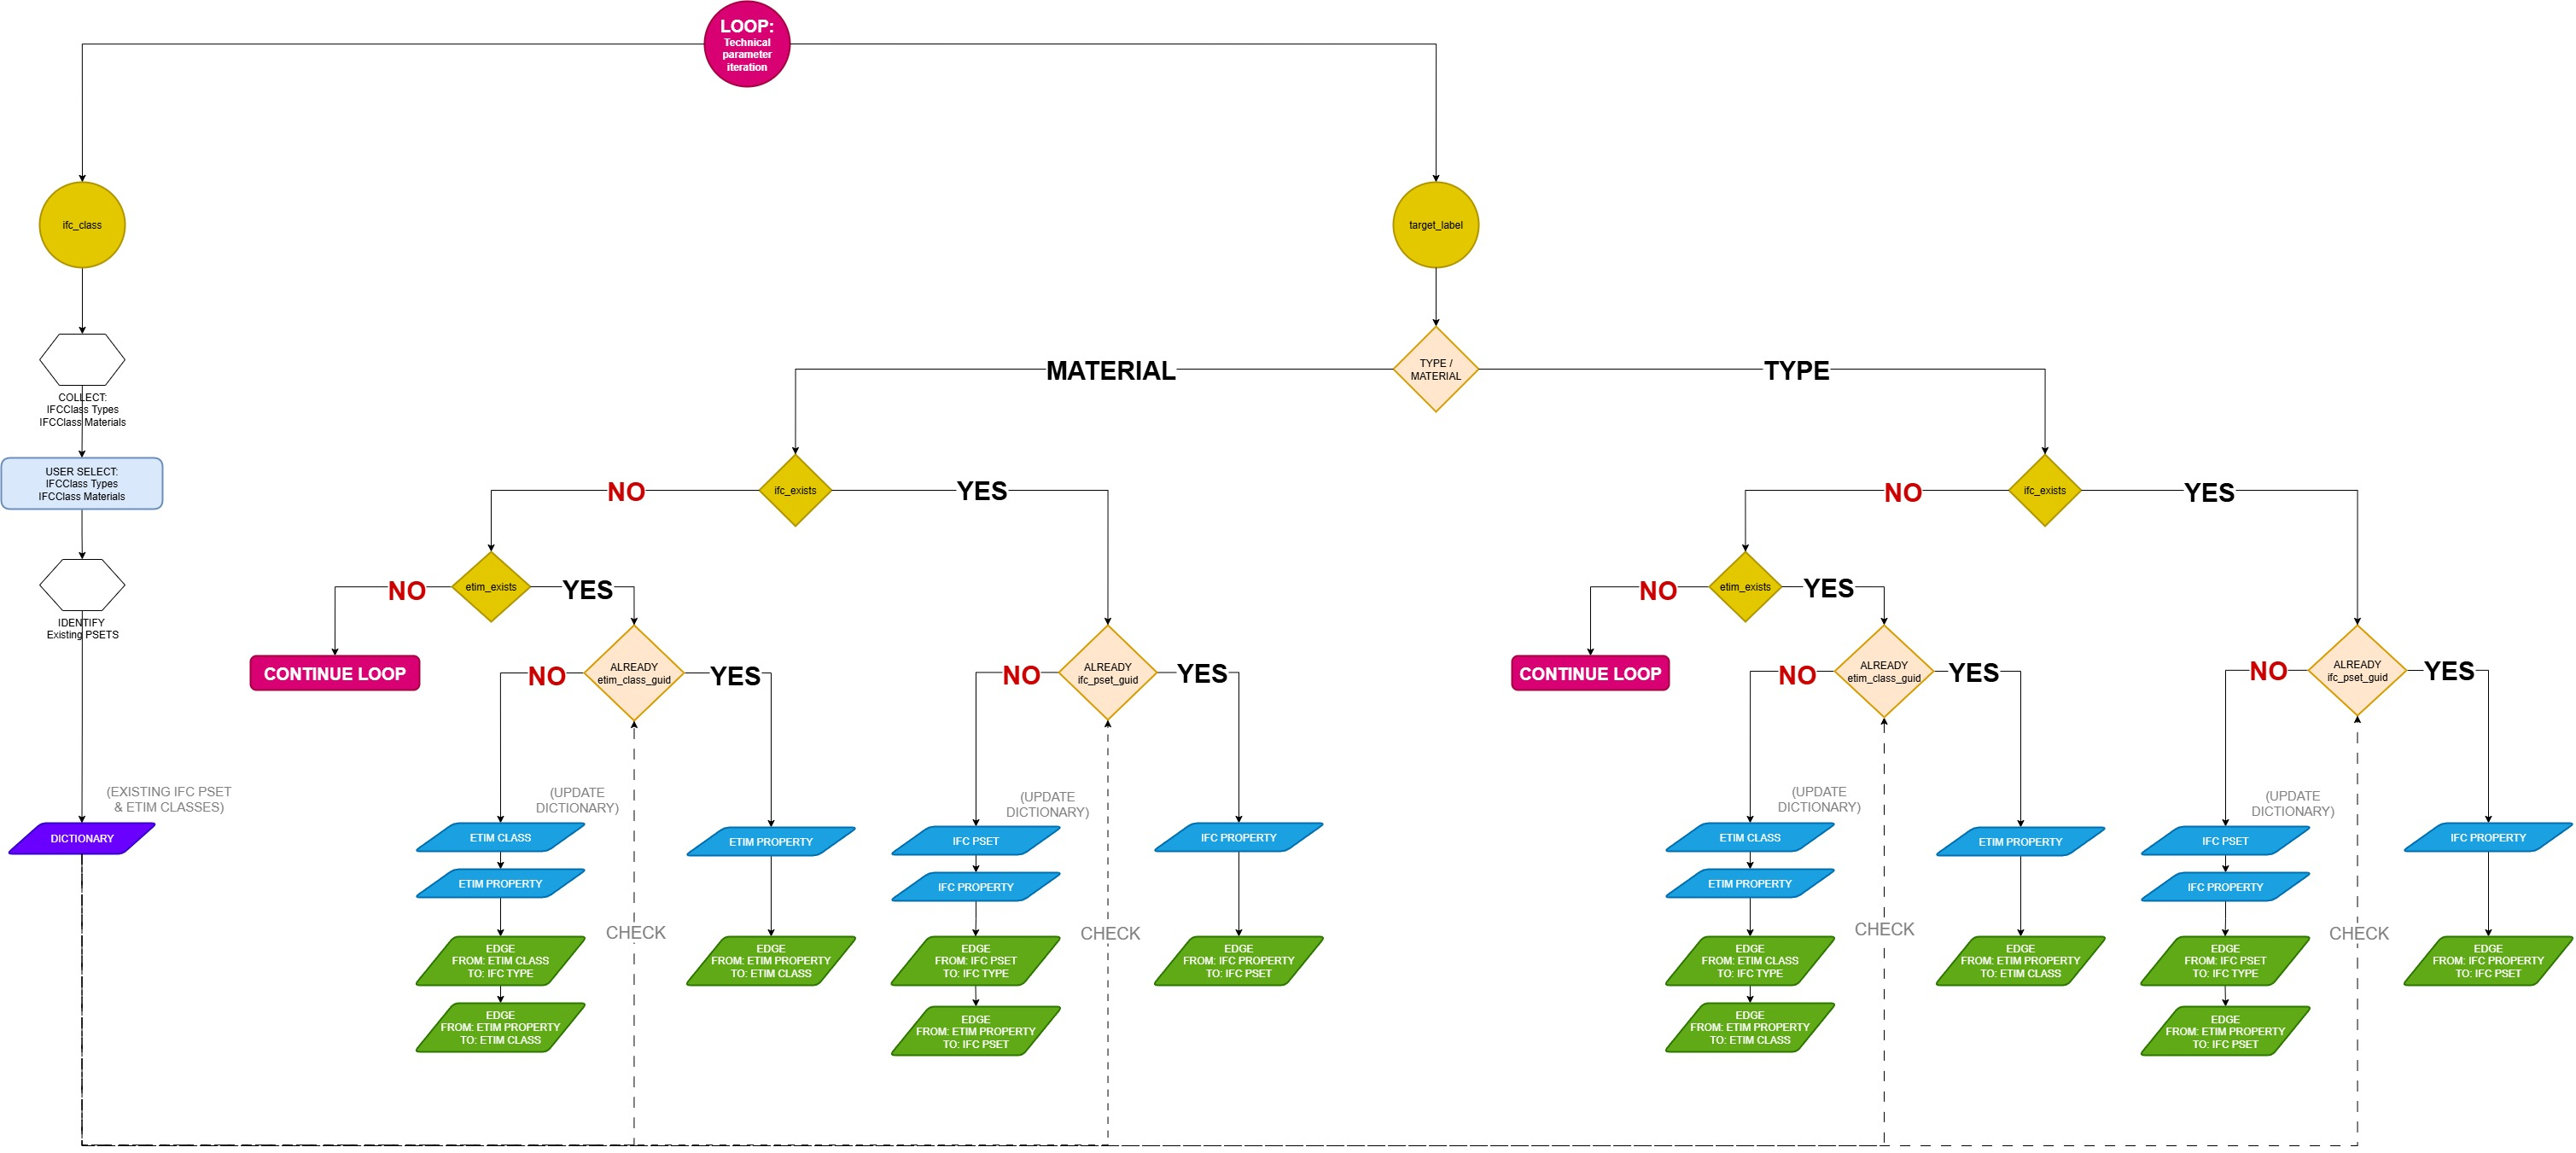

In [9]:
display(Image(filename=authoring_parsing_path))

### 5.1.2. Dictionary structure:

The classes_ifcpset_etimclasses dictionary serves as a central data repository for storing and organizing all existing IFC Property Sets and ETIM Classes identified during the Excel parsing process.  
It ensures that, for each IFC class and its type or material variants, all related property sets and classes are collected, cross-referenced, and updated dynamically to support consistent graph enrichment and prevent duplication across iterations.  

classes_ifcpset_etimclasses = {
    "IfcClass": {
        "type": {
            "ifcpset": {<set_of_ifcpset_GUIDs>},
            "etimclass": {<set_of_etimclass_GUIDs>}
        },
        "material": {
            "ifcpset": {<set_of_ifcpset_GUIDs>},
            "etimclass": {<set_of_etimclass_GUIDs>}
        }
    },
    ...
}

### 5.1.3. Parsing output structure:

**GLOBAL UNIQUE IDENTIFIER (GUID):**
A **GUID (Globally Unique Identifier)** is a 128-bit value used to uniquely identify objects or entities across systems, ensuring no two items share the same identifier.   
In Python, a GUID can be automatically generated using the `uuid` module — for example: `import uuid; guid = str(uuid.uuid4())`.  

**IFC PSET & ETIM CLASS:**

*IFC MODEL IFC PSET:*

In [14]:
node_pset_dict_content_path = r"..\references\nodes_edges_dict_content\node_pset_dict_content.jpg"

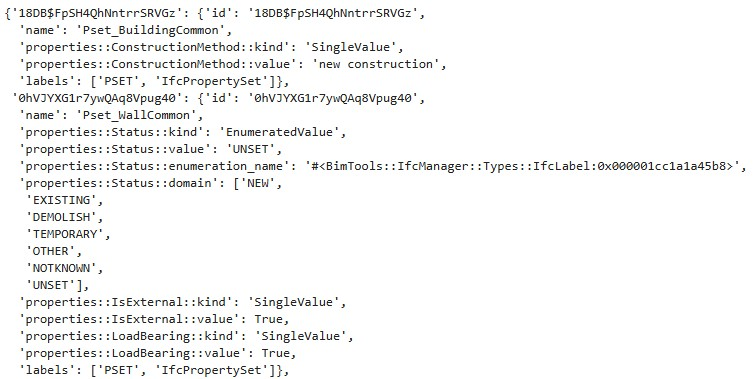

In [15]:
display(Image(filename=node_pset_dict_content_path))

*IFC PSET OUTPUT:*  

{ifc_pset_guid:{  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;id: ifc_pset_guid,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uri: ifc_pset_uri,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;name: ifc_pset_name,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;code: ifc-pset_code,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels: []  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}  

*ETIM CLASS OUTPUT:*  

{ifc_pset_guid:{  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;id: etim_class_guid,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uri: etim_class_uri,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;name: etim_class_name,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;code: etim_class_code,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels: []  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;} 

**IFC PROPERTY & ETIM PROPERTY:**

*IFC/ETIM PROPERTY OUTPUT:*  

{ifc_property_guid/etim_property_guid:{  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;id: ifc_property_guid/etim_property_guid,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uri: ifc_property_uri/etim_property_uri,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;name: ifc_property_name/etim_property_name,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;code: ifc_property_code/etim_property_code,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels: []  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}

**RELATIONSHIP/EDGE:**

In [21]:
edge_dict_content_path = r"..\references\nodes_edges_dict_content\edge_dict_content.jpg"

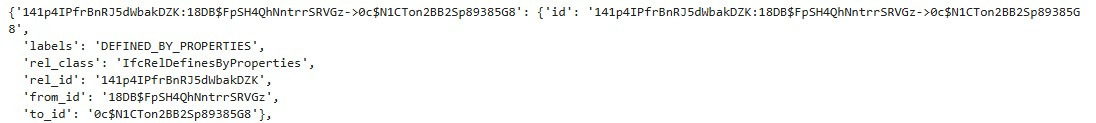

In [22]:
display(Image(filename=edge_dict_content_path))

*RELATIONSHIP/EDGE OUTPUT:*  

{"(rel_id):(from_id)->(to_id)":{  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;id: "(rel_id):(from_id)->(to_id)",  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels: []  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;rel_class: []  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;rel_id: relationship/edge GUID,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;from_id: from entity GUID,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;to_id: to entity GUID,   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}

### "REL_CLASS" STILL TO BE DETERMINED LATER (DEPENDING UPON CASSES).

## 5.2. Authoring Excell file parsing:

# 6. Graph enrichment:

# 7. Post enrichment validation:

# 8. Data save: